In [1]:
import os
import cv2
import numpy as np 
import pandas as pd 
import tifffile
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

target_root = "E:/睡眠分期数据/hubmap/"
img_root = target_root + "test"
filelist = os.listdir(img_root)
pred_csv = pd.read_csv('./work_dir/LB记录/512_resnest50_845/submission.csv')
def get_image_mask(id_):
    image = tifffile.imread('{}/{}.tiff'.format(img_root, id_))
    mask_cod  = pred_csv.loc[pred_csv['id'] == id_]['predicted'].values[0]
    
    if image.ndim == 5:
        image = image[0,0,:,:,:]
        image = np.transpose(image, (1,2,0))
    
    mask = np.zeros((image.shape[0]*image.shape[1]), dtype=np.uint8)
    
    rle_mask = mask_cod.split()
    positions = map(int, rle_mask[::2])
    lengths = map(int, rle_mask[1::2])
    for pos, le in zip(positions, lengths):
        mask[pos-1:pos+le-1] = 1
   
    mask = mask.reshape((image.shape[1], image.shape[0]))

    return image, mask.T

def mask2rle(mask):
    ''' takes a 2d boolean numpy array and turns it into a space-delimited RLE string '''
    mask = mask.T.reshape(-1) # make 1D, column-first
    mask = np.pad(mask, 1, mode="constant") # make sure that the 1d mask starts and ends with a 0
    starts = np.nonzero((~mask[:-1]) & mask[1:])[0] # start points
    ends = np.nonzero(mask[:-1] & (~mask[1:]))[0] # end points
    rle = np.empty(2 * starts.size, dtype=int) # interlacing...
    rle[0::2] = starts + 1# ...starts...
    rle[1::2] = ends - starts # ...and lengths
    rle = ' '.join([ str(elem) for elem in rle ]) # turn into space-separated string
    return rle
pred_csv.head()

,id,predicted
0,26dc41664,157852172 10 157890328 14 157928488 3 15792849...
1,afa5e8098,65764372 8 65801157 4 65801170 11 65801257 1 6...
2,b2dc8411c,56484276 8 56484292 16 56484309 1 56499120 9 5...
3,b9a3865fc,61146712 4 61177983 33 61209261 61 61240556 61...
4,c68fe75ea,912257 1 939097 1 965930 3 965937 1 992769 9 1...


In [2]:
out_info = {}
for id_ in pred_csv['id']:
    image, mask = get_image_mask(id_)
    image_re = cv2.resize(image, (2048, 2048))
    mask_re = cv2.resize(mask, (2048, 2048))
    label_img = label(mask_re, connectivity = mask.ndim)
    props = regionprops(label_img)
    for p in props:
        if p.area > 60:
            continue
        bbox = p.bbox
        bbox = list(bbox)
        bbox[0] = int(bbox[0]* mask.shape[0]/2048)
        bbox[2] = int(bbox[2]* mask.shape[0]/2048)
        bbox[1] = int(bbox[1]* mask.shape[1]/2048)
        bbox[3] = int(bbox[3] * mask.shape[1]/2048)
        mask[bbox[0]:bbox[2], bbox[1]:bbox[3]] = 0
    
    out_info[len(out_info)] = {'id':id_, 'predicted': mask2rle(mask)}
submission = pd.DataFrame.from_dict(out_info, orient='index')
submission.to_csv('fixed_submission.csv', index=False)

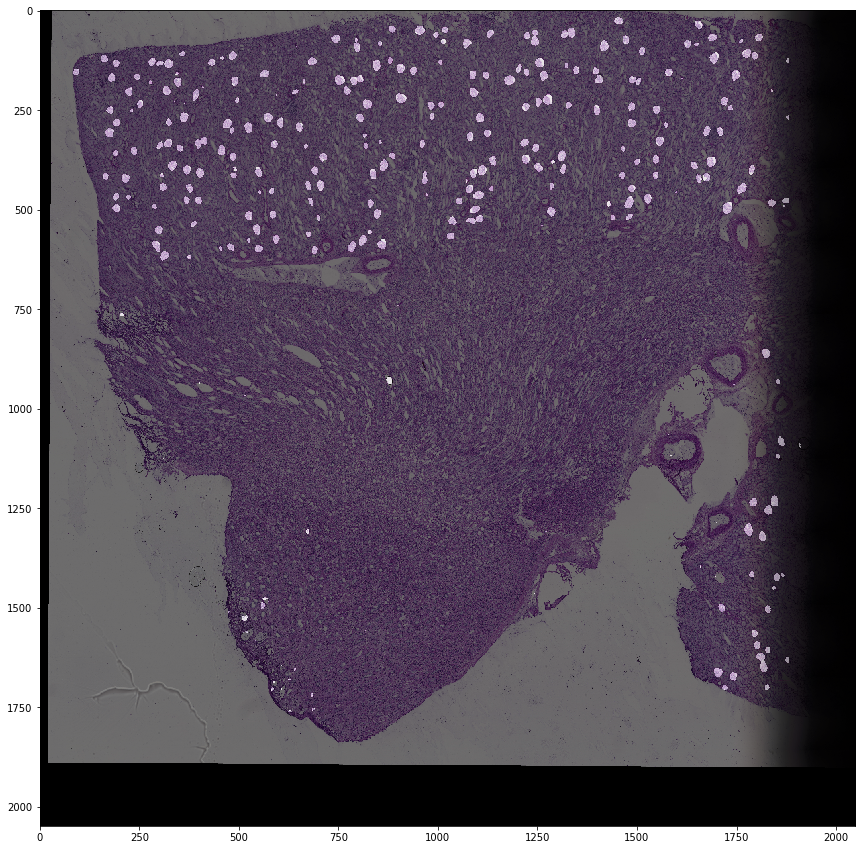

In [7]:
image, mask = get_image_mask("afa5e8098")
image_re = cv2.resize(image, (2048, 2048))
mask_re = cv2.resize(mask, (2048, 2048))
plt.figure(figsize=(15,15))
plt.imshow(image_re)
plt.imshow(mask_re,alpha=0.5, cmap='gray')
plt.show()

mask数量 304


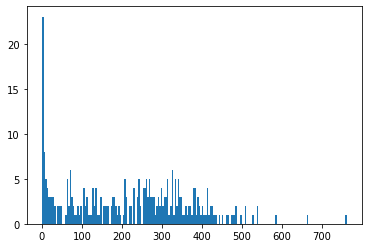

In [8]:
label_img = label(mask_re, connectivity = mask.ndim)
props = regionprops(label_img)
print("mask数量", len(props))
areas = []
for p in props:
    areas.append(p.area)
areas = np.array(areas)
plt.hist(areas, bins=200)
plt.show()

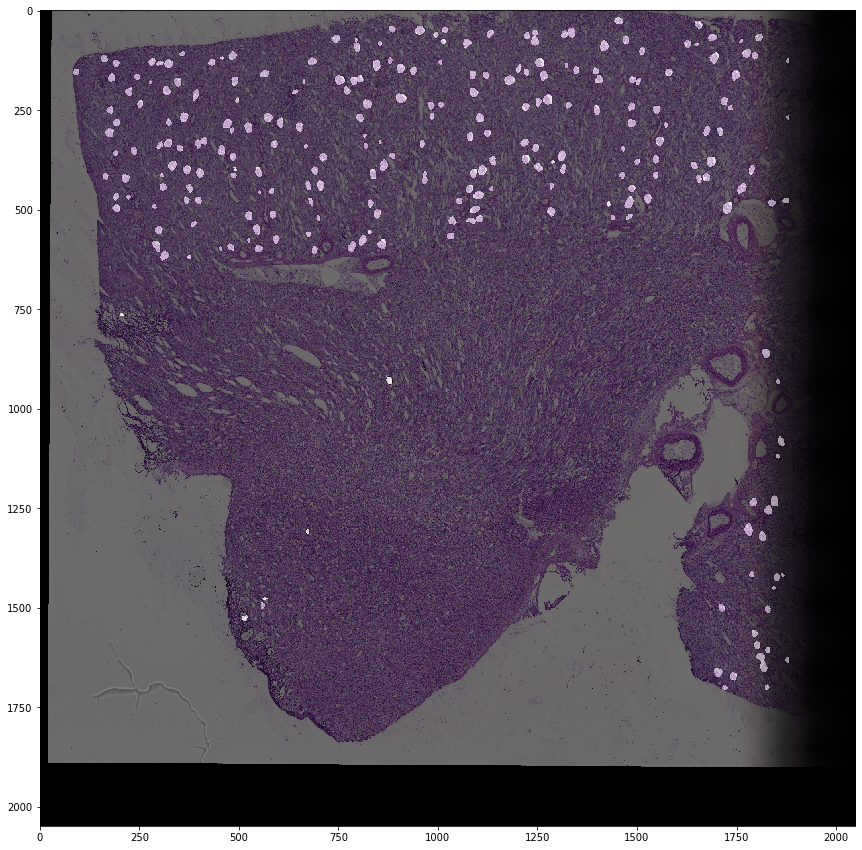

In [9]:
mask_process = mask.copy()
for p in props:
    if p.area > 60:
        continue
    bbox = p.bbox
    bbox = list(bbox)
    bbox[0] = int(bbox[0]* mask.shape[0]/2048)
    bbox[2] = int(bbox[2]* mask.shape[0]/2048)
    bbox[1] = int(bbox[1]* mask.shape[1]/2048)
    bbox[3] = int(bbox[3] * mask.shape[1]/2048)
    mask_process[bbox[0]:bbox[2], bbox[1]:bbox[3]] = 0
mask_re_p = cv2.resize(mask_process, (2048, 2048))
plt.figure(figsize=(15,15))
plt.imshow(image_re)
plt.imshow(mask_re_p,alpha=0.5, cmap='gray')
plt.show()

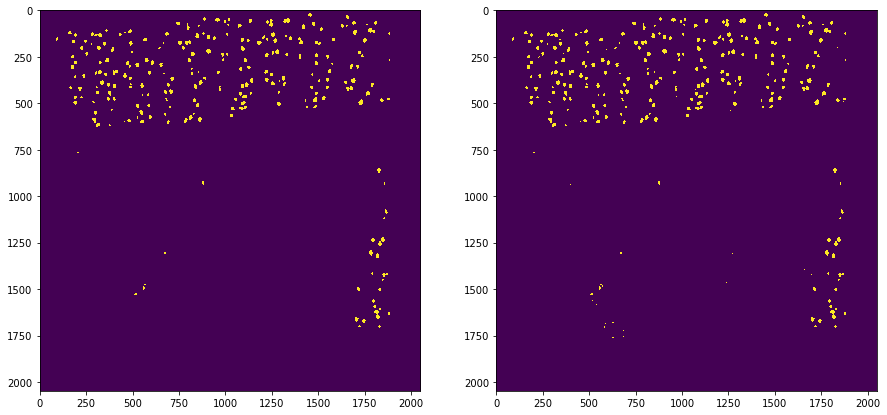

In [10]:
plt.figure(figsize=(15,15))
# plt.imshow(image_re)
plt.subplot("121")
plt.imshow(mask_re_p)
plt.subplot("122")
plt.imshow(mask_re)
plt.show()

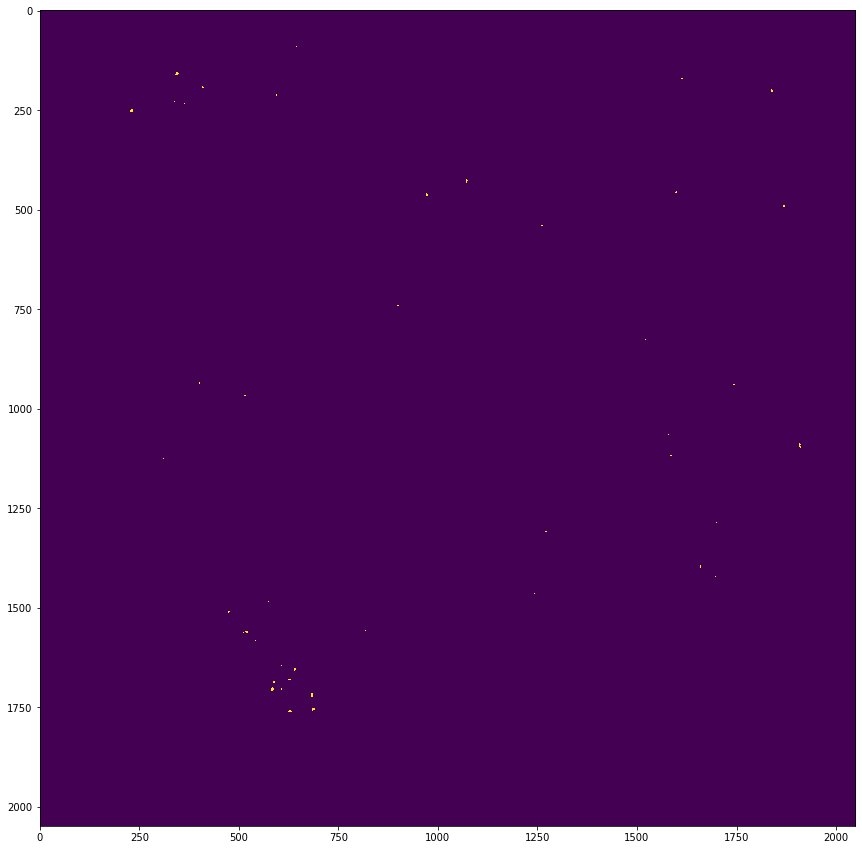

In [11]:
plt.figure(figsize=(15,15))
plt.imshow(mask_re-mask_re_p)
plt.show()